In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #for visualization
import torch
import torch.nn as nn
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.random.seed(1)
torch.manual_seed(1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
### Instructions for the students using Google Colab
### If you are using Google Colab, you will need to first mount the google drive. You can do this by running the following code after uncommenting it.
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

### You also need to upload the data to your Google drive.
### Make sure you are using the same google account for both Google Colab and Google Drive.

### For example, if the dataset data.npy is located in /content/drive/My Drive/CME216/HW5/PartA, then you can use the following code to load the data.
# data_path = '/content/drive/MyDrive/CME216/HW5/PartA'
# data = np.load(f'{data_path}/data.npy')
### OR else.....
### you can cd to the directory where the data is located using the following command
# %cd /content/drive/MyDrive/CME216/HW5/PartA
### And then load the data. Make sure that the notebook is running in the same directory where the data is located.
# data = np.load('data.npy')

Mounted at /content/drive


## Q1: Data wrangling

In [ ]:
# load data
from torch.utils.data import TensorDataset, DataLoader

X = np.load("/content/drive/MyDrive/ME343/HW5A/u0_data.npy")
Y = np.load("/content/drive/MyDrive/ME343/HW5A/uT_data.npy")

# split data into training, validation and test sets
X_flatten = X.reshape(len(X), -1)
Y_flatten = Y.reshape(len(Y), -1)

train_split, val_split = int(len(X)*0.8), int(len(X)*0.9)
X_train, X_test, X_validation = X_flatten[:train_split], X_flatten[train_split:val_split], X_flatten[val_split:]
Y_train, Y_test, Y_validation = Y_flatten[:train_split], Y_flatten[train_split:val_split], Y_flatten[val_split:]

# create corresponding PyTorch tensors
print(X_flatten.dtype)
X_train_tensor = torch.from_numpy(X_train).float().to(device)
Y_train_tensor = torch.from_numpy(Y_train).float().to(device)
X_validation_tensor = torch.from_numpy(X_validation).float().to(device)
Y_validation_tensor = torch.from_numpy(Y_validation).float().to(device)
X_test_tensor = torch.from_numpy(X_test).float().to(device)
Y_test_tensor = torch.from_numpy(Y_test).float().to(device)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
validation_dataset = TensorDataset(X_validation_tensor, Y_validation_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# create Pytorch dataloaders
train_loader = DataLoader(train_dataset)
validation_loader = DataLoader(validation_dataset)
test_loader = DataLoader(test_dataset,shuffle=True)


float64


## Q2: Model construction

In [ ]:
# Define a simple fully connected network class with following arguments:
# input_dim: input dimension
# output_dim: output dimension
# n_layers: number of layers (counted as number of hidden layers + 1 output layer)
# n_units: number of neurons in each layer
# activation: type of activation function (NOTE: there should be no activation function in the output layer)

class FullyConnectedNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, n_layers, n_units, activation):
        super(FullyConnectedNetwork, self).__init__()  #we create a temporaty object of superclass(parent class), and then call the constructor to initialize
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(input_dim,n_units))
        for _ in range( n_layers-1):
            self.layers.append(torch.nn.Linear(n_units,n_units))
        self.layers.append(torch.nn.Linear(n_units,output_dim))
        self.act = activation

    def forward(self, x):
        for layer in self.layers[:-1]:  #no activation in last layers
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x


## Helper functions
You may use the following functions in train_and_plot function below

In [ ]:
# function to compute relative L2 error in percentage
def rel_l2_error(pred, true):
    """A helper function to compute the relative L2 error in percentage

    Args:
        pred (torch.Tensor): Predicted values
        true (torch.Tensor): True values

    Returns:
        torch.Tensor: Relative L2 error in percentage
    """
    return (torch.norm(pred - true) / torch.norm(true))*100


# prediction plotting function
def prediction_plots(n_plots, indices, u0, uT, output):
    """A helper function to plot the predictions of the model

    Args:
        n_plots (int): Number of plots to display
        indices (list): List of indices to plot
        u0 (np.array): Initial condition (3D numpy array of shape (n_samples, D, D))
        uT (np.array): Target condition (3D numpy array of shape (n_samples, D, D))
        output (np.array): Model output (3D numpy array of shape (n_samples, D, D))
    """
    fig, axs = plt.subplots(n_plots, 4, figsize=(20, 5*n_plots))
    for i, idx in enumerate(indices):
        im = axs[i, 0].imshow(u0[idx, :, :], cmap='viridis')
        divider = make_axes_locatable(axs[i, 0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        im = axs[i, 1].imshow(uT[idx, :, :], cmap='viridis')
        divider = make_axes_locatable(axs[i, 1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        im = axs[i, 2].imshow(output[idx, :, :], cmap='viridis')
        divider = make_axes_locatable(axs[i, 2])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        im = axs[i, 3].imshow(output[idx, :, :]-uT[idx, :, :], cmap='viridis')
        divider = make_axes_locatable(axs[i, 3])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    axs[0, 0].set_title('Initial condition (u(x, 0))')
    axs[0, 1].set_title('Target condition (u(x, T))')
    axs[0, 2].set_title('DNN prediction (u_pred(x, T))')
    axs[0, 3].set_title('Error')
    for ax in axs.flatten():
        ax.axis('off')
    plt.show()



## Q3: Training function

In [ ]:
# write train_and_plot function here...

# 10 points. Training routine: Write a function called train and plot which takes as argument
# following things:
# • model (model – an object instantiation of the class FullyConnectedNetwork)
# • optimizer (type of optimizer for performing gradient updates)
# • max epochs (maximum number of epochs)
# • batch size (number of samples in each batch)
import random
random.seed(42)

def train_and_plot(model, optimizer, max_epoches, batch_size):
    print("----------------------------------------------------------------------------------------------------------")
    print("Current Optimizer is", optimizer.__class__.__name__)
    train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size,shuffle=True)
    criterion = torch.nn.MSELoss()
    training_loss_list = []
    validation_loss_list =[]
    total_train_loss = 0.0
    model.to(device)
    for epoch in range(max_epoches):
        model.train()
        total_train_loss = 0.0
        for X_batch, Y_batch in  train_loader:
            X_batch, Y_batch = X_batch.to(device).float(), Y_batch.to(device).float()   # change dtype to float32 to match the model
            outputs = model(X_batch)
            training_loss = criterion(outputs,Y_batch)

            optimizer.zero_grad()
            training_loss.backward()
            optimizer.step()

        # average_train_loss = total_train_loss / len(train_loader)

        if (epoch + 1)%100 == 0:
            training_loss_list.append(training_loss.item())
            model.eval()   #ensure that all layers are in inference mode.
            with torch.no_grad():  #temporarily set all reuire_gradient to false

                val_pred_field = model(X_validation_tensor)
                val_loss = criterion(val_pred_field, Y_validation_tensor)
                MRE = rel_l2_error(val_pred_field, Y_validation_tensor)/len(Y_validation_tensor)
                validation_loss_list.append(val_loss.item())

                print(f"Current Epoch: {epoch+1}/{max_epoches}") # f stands for "formatted string literal"
                print(f"The training loss is {training_loss.item()}") #loss itself is a tensor
                print(f"The validation loss is {val_loss.item()}") #loss itself is a tensor
                print(f"The mean relative error (in percentage) for the validation set: {MRE}")

    plt.figure()
    tick_interval = 100
    epoches = range(100, max_epoches + 1, tick_interval)
    plt.plot(epoches, training_loss_list, label = "Training Loss")
    plt.plot(epoches, validation_loss_list, label = "Validation Loss")
    plt.title("Loss history of training and validation test")
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")


    plt.grid()
    plt.legend()
    plt.show()

    n_plots = 10
    random_indices = random.sample(range(len(test_loader)), n_plots)
    test_inputs, test_outputs, predict_outputs = [], [], []   # Python lists are versatile and can hold elements of different types
    model.eval()
    with torch.no_grad():
        for input, output in test_loader:
            predict = model(input.to(device).float())
            test_inputs.append(input.cpu().numpy().reshape(26,26))
            test_outputs.append(output.cpu().numpy().reshape(26,26))
            predict_outputs.append(predict.cpu().numpy().reshape(26,26))
    prediction_plots(n_plots, random_indices, np.array(test_inputs), np.array(test_outputs), np.array(predict_outputs))



## Q4: Optimizers

----------------------------------------------------------------------------------------------------------
Current Optimizer is SGD
Current Epoch: 100/2000
The training loss is 0.7075077891349792
The validation loss is 0.7195273637771606
The mean relative error (in percentage) for the validation set: 0.10006172209978104
Current Epoch: 200/2000
The training loss is 0.7116252183914185
The validation loss is 0.7176152467727661
The mean relative error (in percentage) for the validation set: 0.09992866963148117
Current Epoch: 300/2000
The training loss is 0.6897479891777039
The validation loss is 0.7157123684883118
The mean relative error (in percentage) for the validation set: 0.09979609400033951
Current Epoch: 400/2000
The training loss is 0.6850554347038269
The validation loss is 0.7138187885284424
The mean relative error (in percentage) for the validation set: 0.09966399520635605
Current Epoch: 500/2000
The training loss is 0.6904100179672241
The validation loss is 0.711929976940155
The

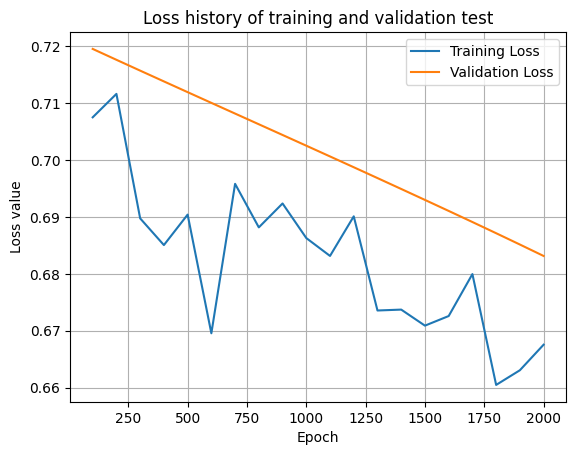

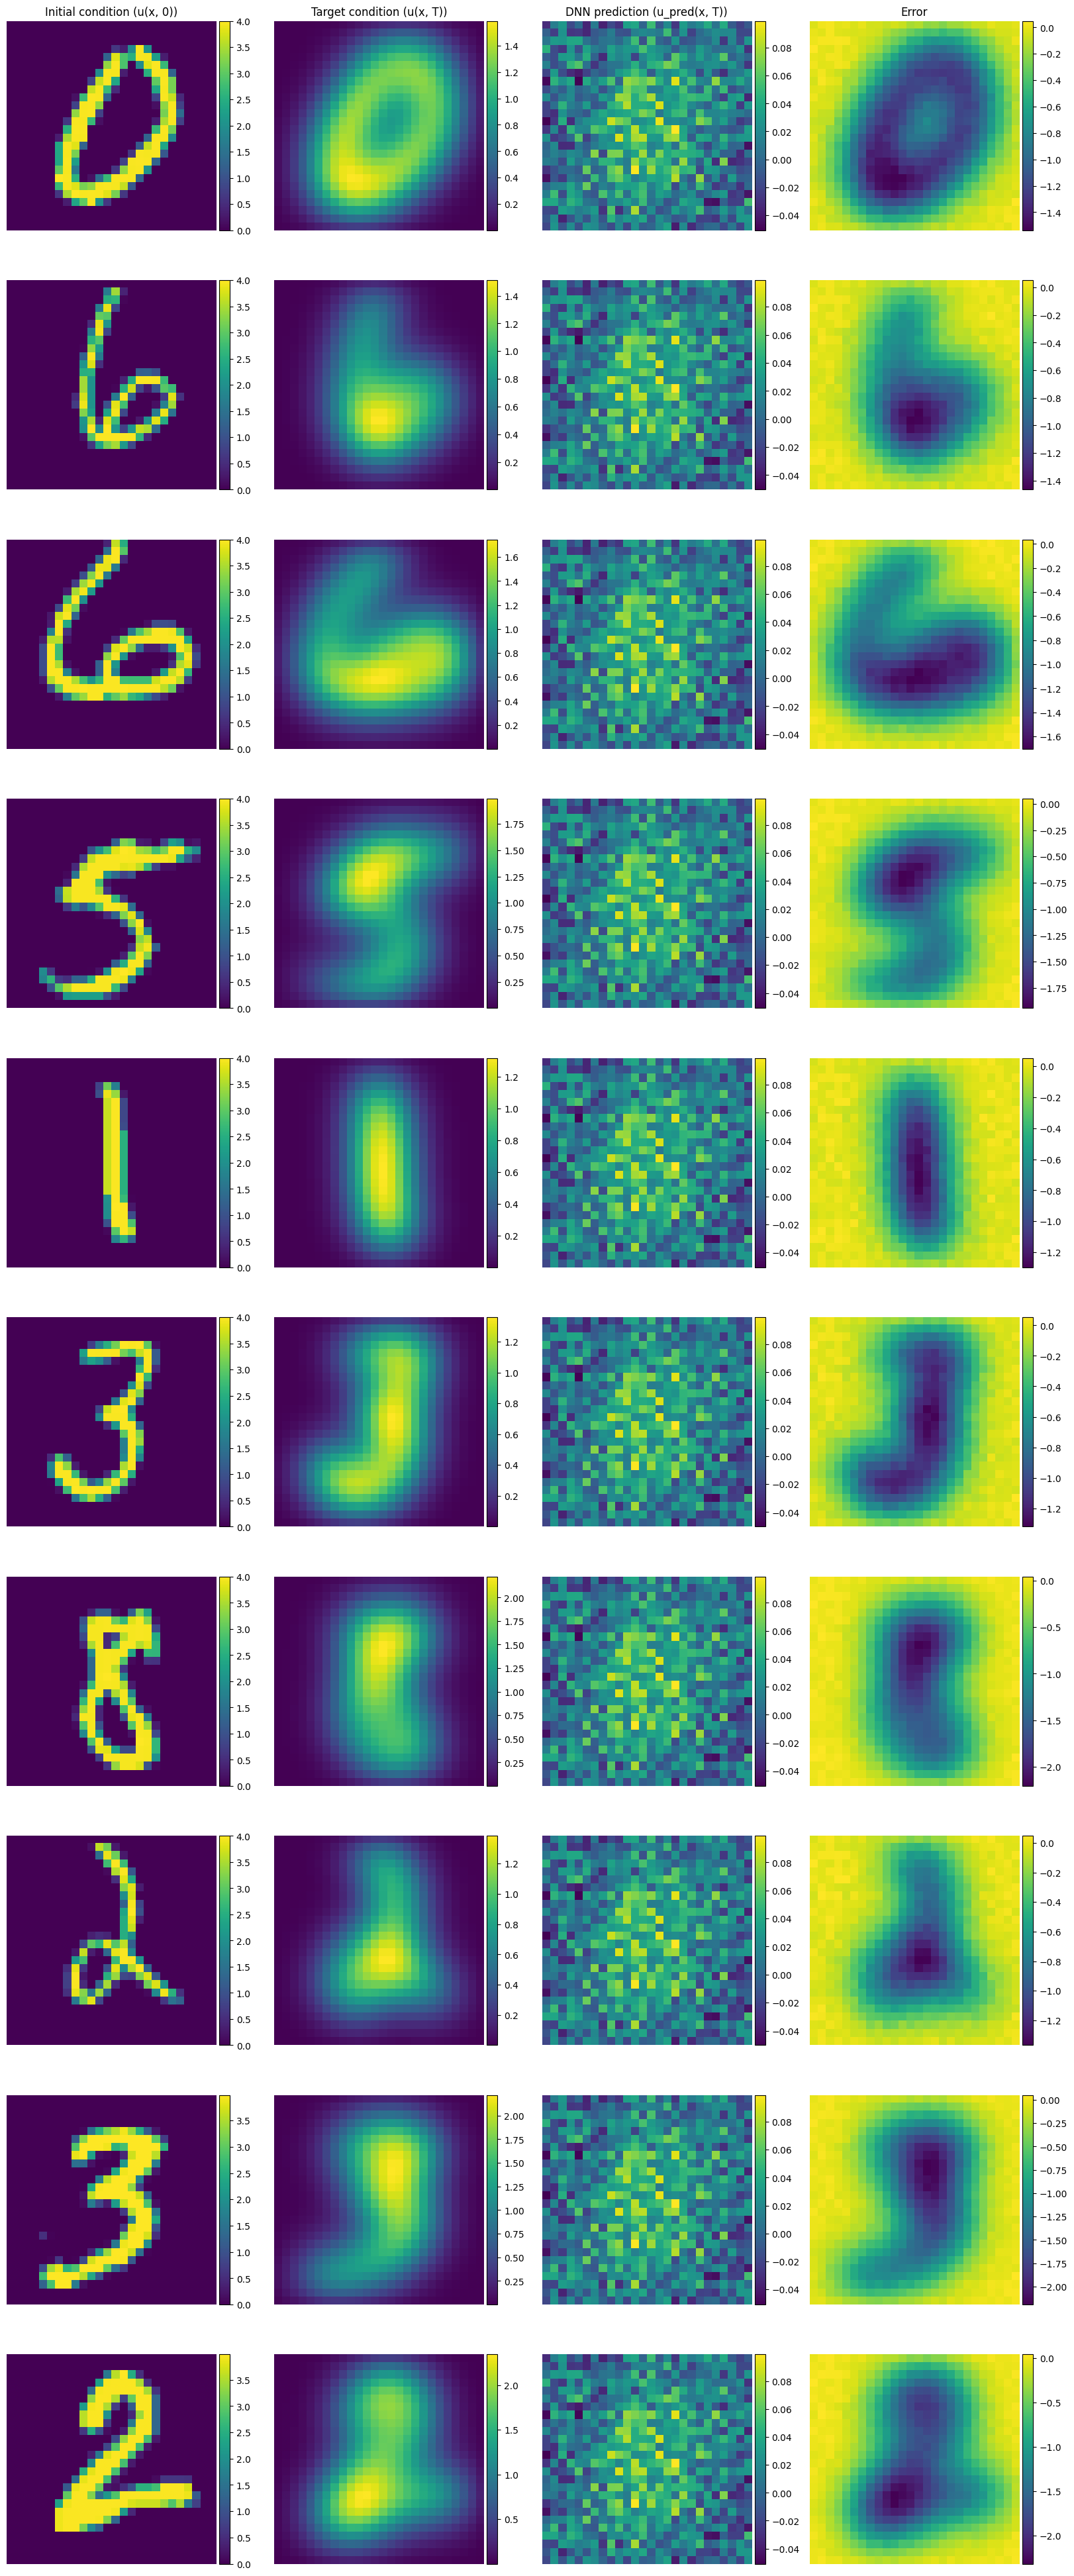

In [ ]:
# write your code here...
#full batch gradient descent
model = FullyConnectedNetwork(input_dim=676, output_dim=676, n_layers=8, n_units=700, activation=torch.nn.ReLU())
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=1e-3)
train_and_plot(model=model, optimizer=optimizer_SGD, max_epoches=2000, batch_size=2000)

----------------------------------------------------------------------------------------------------------
Current Optimizer is SGD
Current Epoch: 100/2000
The training loss is 0.7237041592597961
The validation loss is 0.7173668146133423
The mean relative error (in percentage) for the validation set: 0.09991138428449631
Current Epoch: 200/2000
The training loss is 0.6888101100921631
The validation loss is 0.7134198546409607
The mean relative error (in percentage) for the validation set: 0.09963613748550415
Current Epoch: 300/2000
The training loss is 0.6927688717842102
The validation loss is 0.7094918489456177
The mean relative error (in percentage) for the validation set: 0.09936146438121796
Current Epoch: 400/2000
The training loss is 0.6905989050865173
The validation loss is 0.7055647969245911
The mean relative error (in percentage) for the validation set: 0.09908609837293625
Current Epoch: 500/2000
The training loss is 0.6930830478668213
The validation loss is 0.7016251683235168
Th

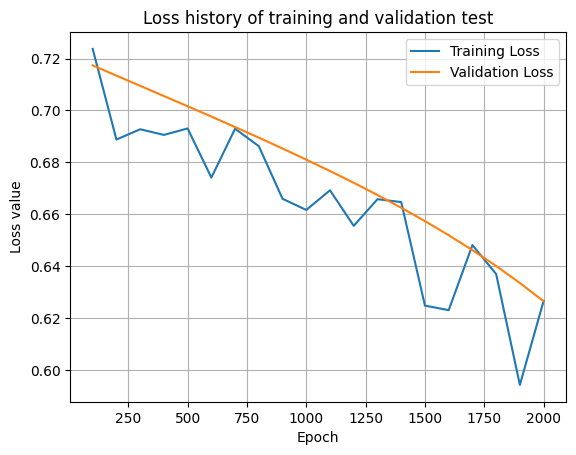

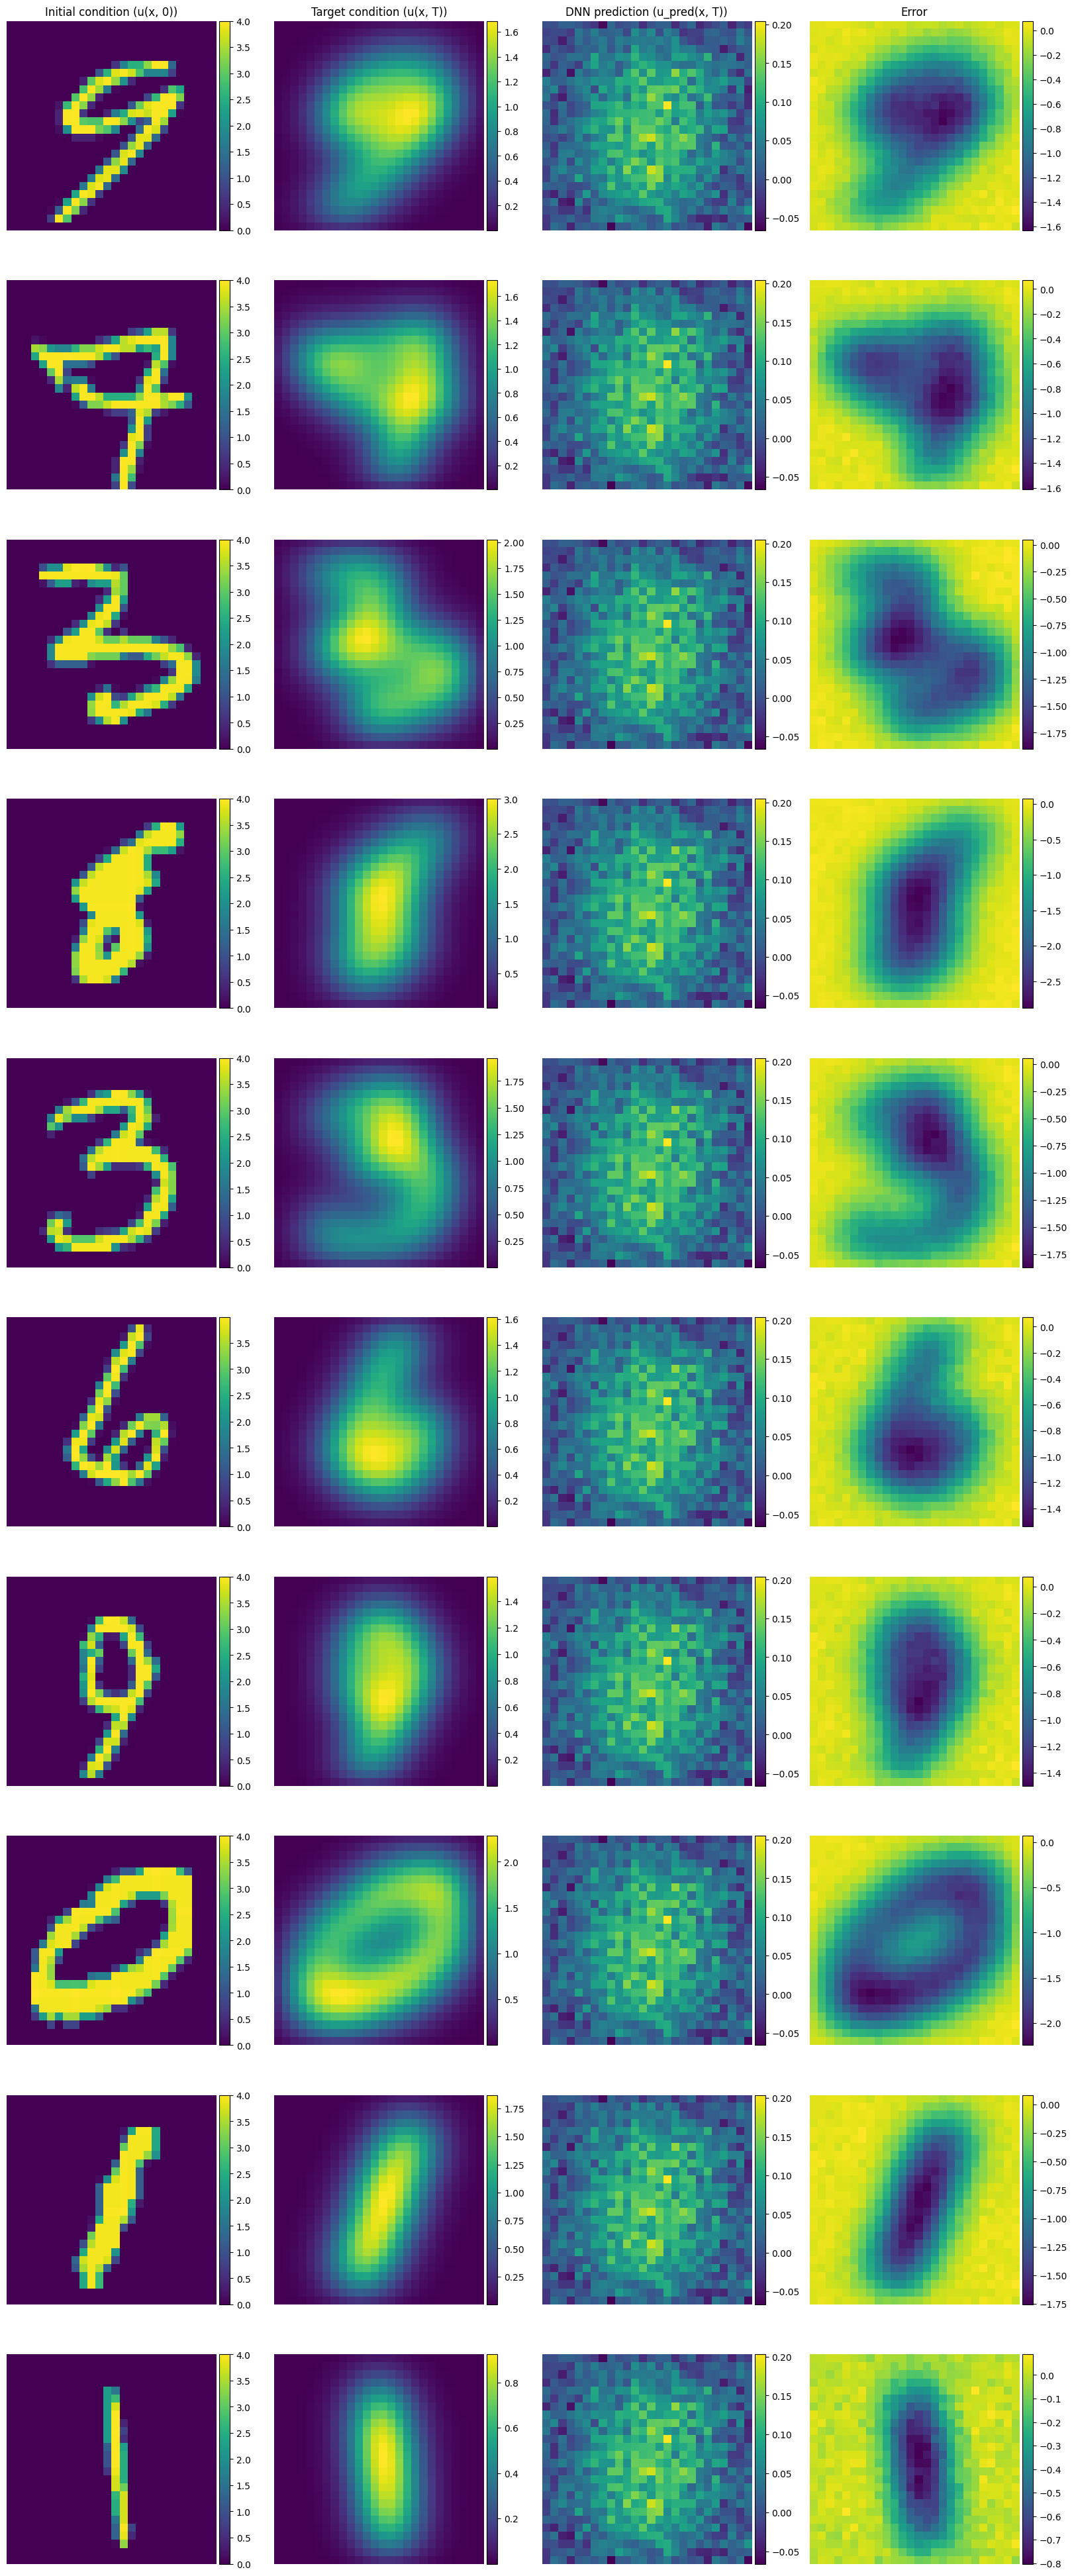

In [ ]:
#minBatch
model = FullyConnectedNetwork(input_dim=676, output_dim=676, n_layers=8, n_units=700, activation=torch.nn.ReLU())
optimizer_minBatch = torch.optim.SGD(model.parameters(), lr=1e-3)
train_and_plot(model=model, optimizer=optimizer_minBatch, max_epoches=2000, batch_size=1024)

----------------------------------------------------------------------------------------------------------
Current Optimizer is Adam
Current Epoch: 100/2000
The training loss is 0.015514528378844261
The validation loss is 0.016228122636675835
The mean relative error (in percentage) for the validation set: 0.015027211979031563
Current Epoch: 200/2000
The training loss is 0.006106599234044552
The validation loss is 0.006619936786592007
The mean relative error (in percentage) for the validation set: 0.009597789496183395
Current Epoch: 300/2000
The training loss is 0.0027493832167237997
The validation loss is 0.003575949463993311
The mean relative error (in percentage) for the validation set: 0.007054072804749012
Current Epoch: 400/2000
The training loss is 0.0014854194596409798
The validation loss is 0.0019253952195867896
The mean relative error (in percentage) for the validation set: 0.005176118575036526
Current Epoch: 500/2000
The training loss is 0.0008588264463469386
The validation lo

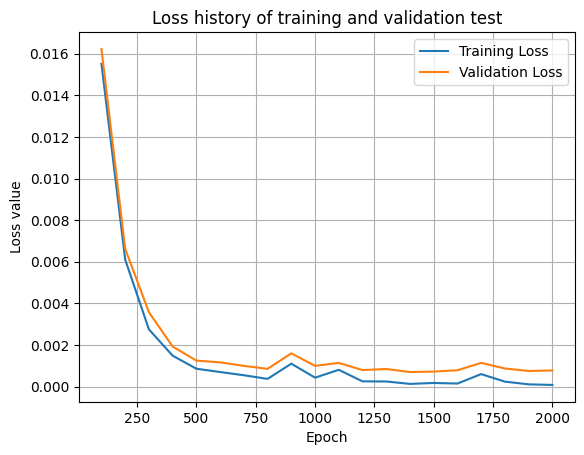

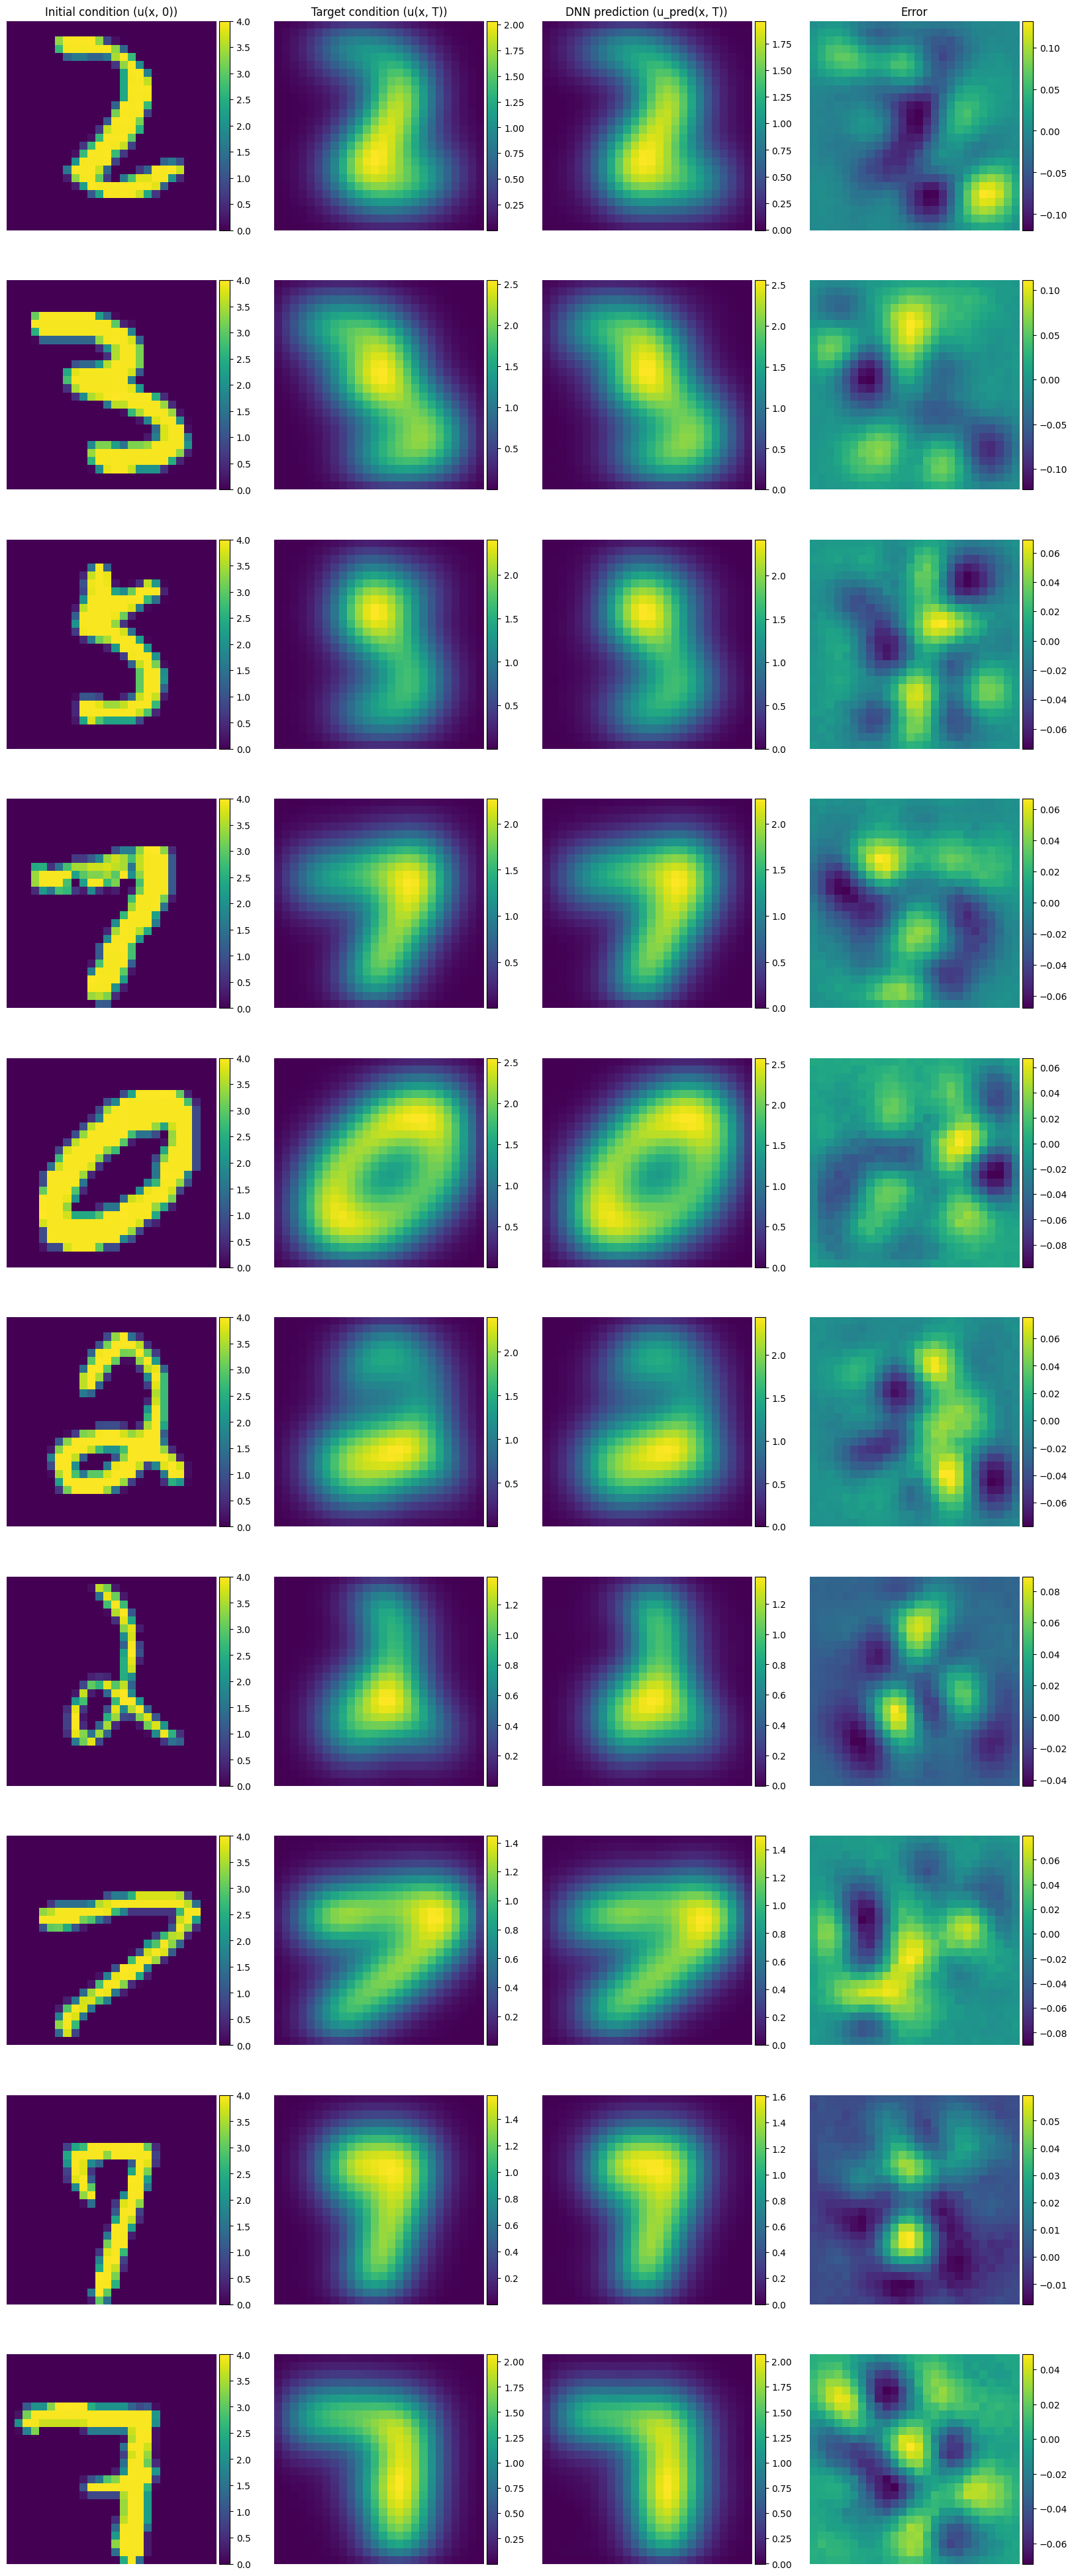

In [ ]:
#Adam
model = FullyConnectedNetwork(input_dim=676, output_dim=676, n_layers=8, n_units=700, activation=torch.nn.ReLU())
optimizer_Adam = torch.optim.Adam(model.parameters(), lr=1e-3)
train_and_plot(model=model, optimizer=optimizer_Adam, max_epoches=2000, batch_size=1024)

----------------------------------------------------------------------------------------------------------
Current Optimizer is RMSprop
Current Epoch: 100/2000
The training loss is 0.058554090559482574
The validation loss is 0.06661392003297806
The mean relative error (in percentage) for the validation set: 0.030445756390690804
Current Epoch: 200/2000
The training loss is 0.026839010417461395
The validation loss is 0.03431284800171852
The mean relative error (in percentage) for the validation set: 0.02185106836259365
Current Epoch: 300/2000
The training loss is 0.015711728483438492
The validation loss is 0.017984842881560326
The mean relative error (in percentage) for the validation set: 0.015819676220417023
Current Epoch: 400/2000
The training loss is 0.024082303047180176
The validation loss is 0.016994325444102287
The mean relative error (in percentage) for the validation set: 0.015377872623503208
Current Epoch: 500/2000
The training loss is 0.015196193940937519
The validation loss i

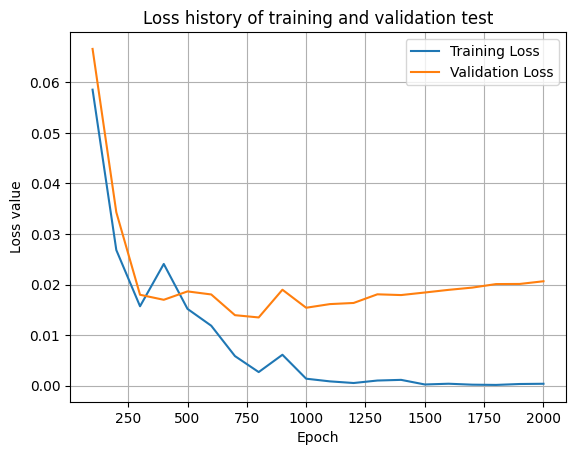

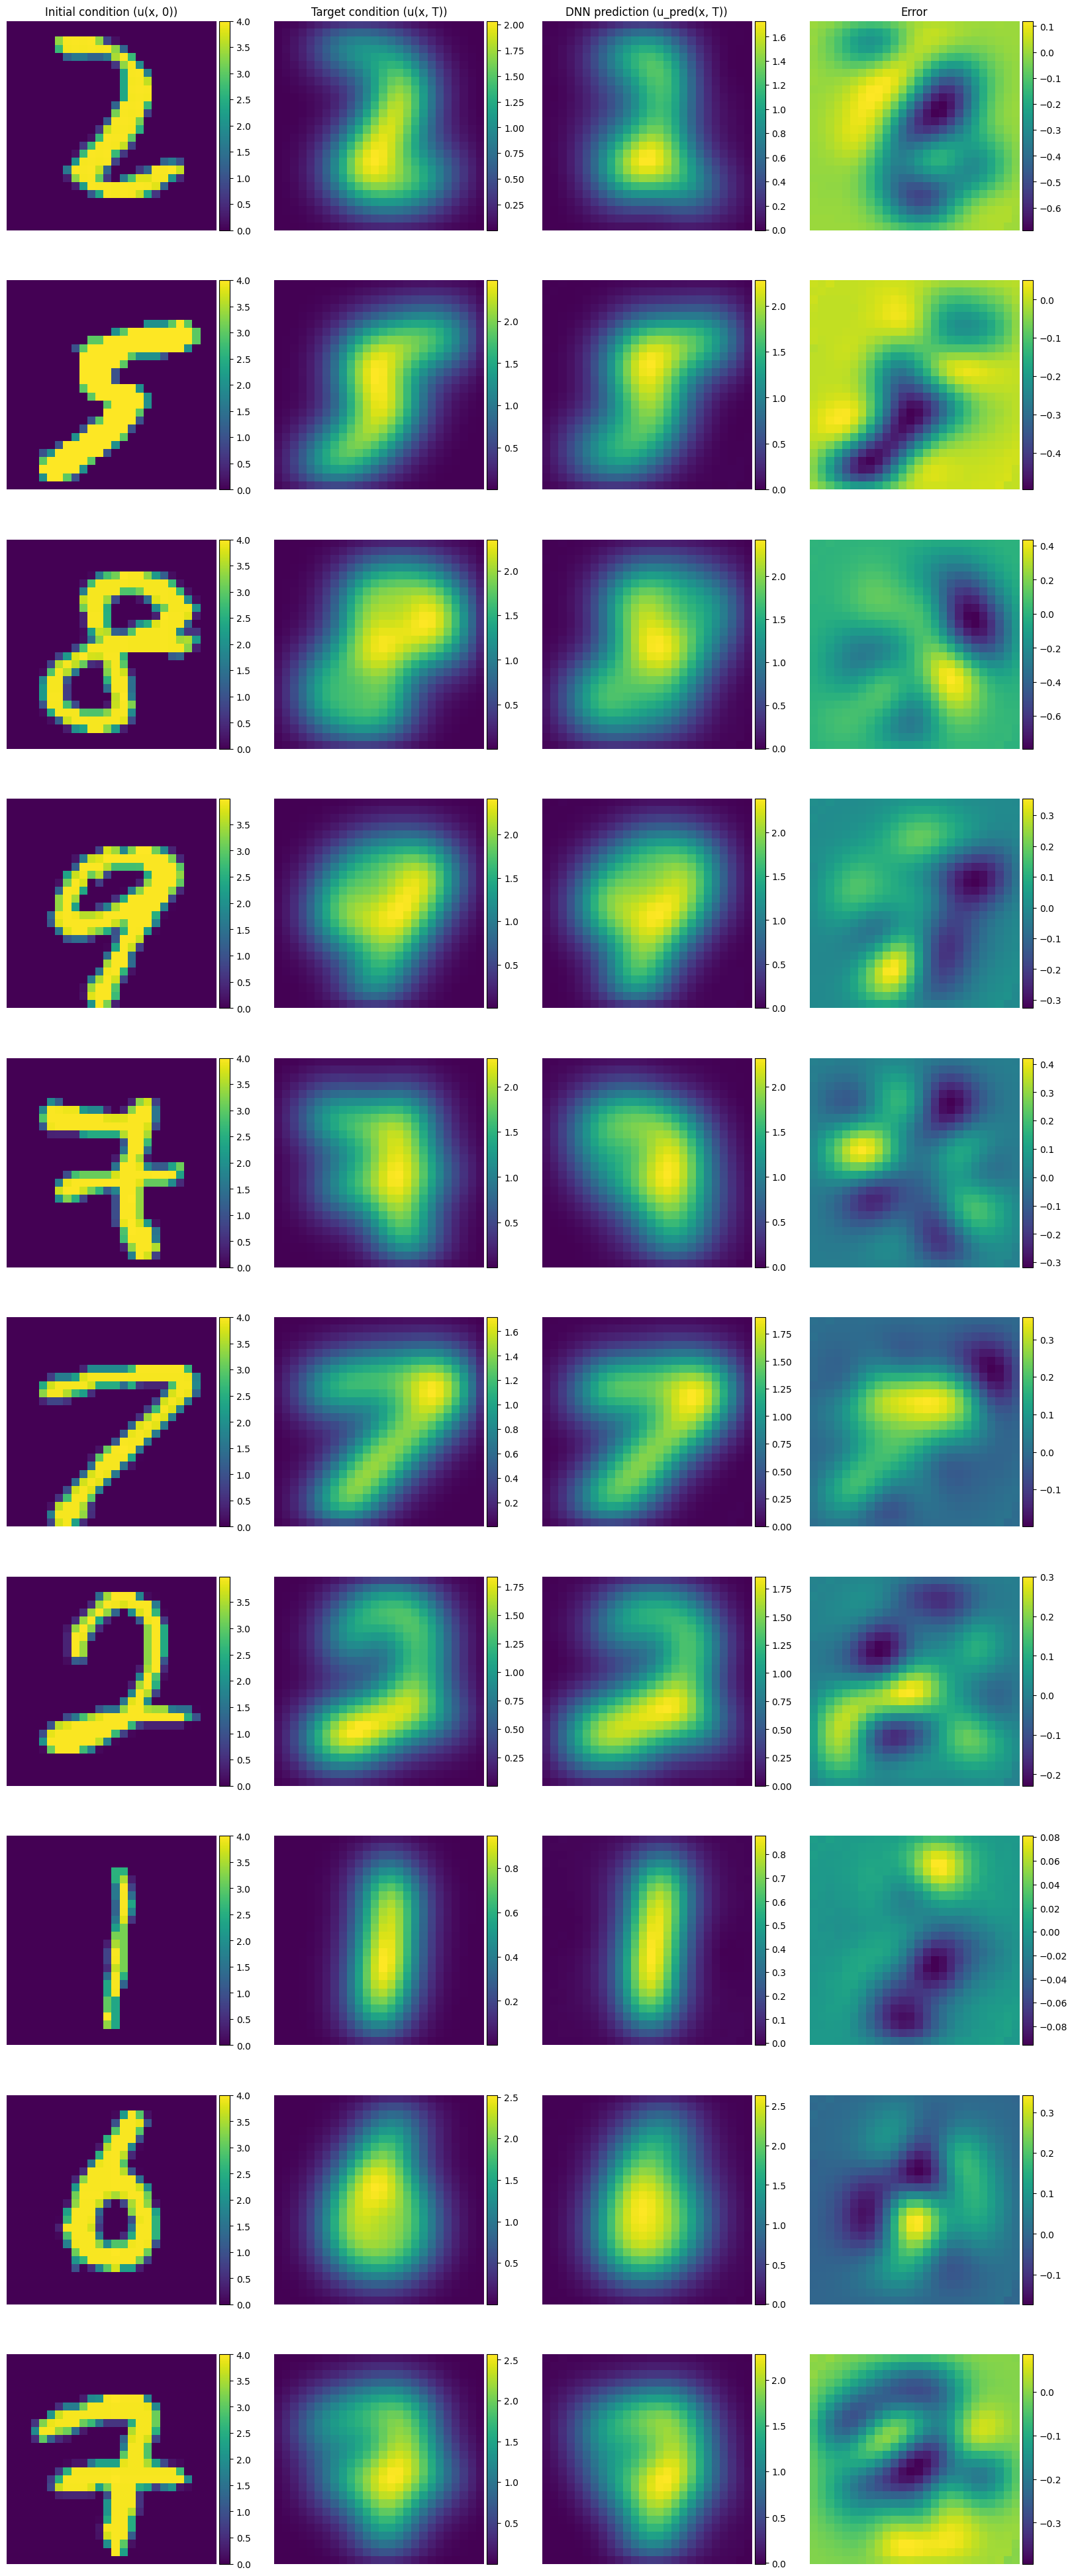

In [ ]:
#RMSprop
optimizer_RMSprop = torch.optim.RMSprop(model.parameters(), lr=1e-3)
train_and_plot(model=model, optimizer=optimizer_RMSprop, max_epoches=2000, batch_size=1024)

Use this text cell to: comment on your observations. Which optimizer performs best? Which criteria are you using to
judge the relative performance of different optimizers and reach at your conclusion.

When we look at the four optimizers, full batch and mini batch didn't do well in predicting test results as yielding blurring images. Full batch is even worse than mini batch considering its even higher losses, making them the less favorable options in this problem.

On the other hand side, Adam and RMSProp are better at predicting test outcomes. Both success to generate a result which is close to the ground trut In addition, Adam shows a clear and stable improvement, and its loss is much smaller than that of RMSProp. It it probably because Adam not only maintainis a moving average of the squared gradients, but also  keeps an exponentially decaying average of past gradients similar to momentum. Combining these advantages make it the most effective optimizer among the four.

In a word, Adam is the top choice for our model as it gives a significantly better and more stable results compared to the others.

## Q5: Tuning learning rate for the optimal optimizer (learning_rate=[1e-5, 1e-2, 1])

----------------------------------------------------------------------------------------------------------
Current Optimizer is Adam
Current Epoch: 100/2000
The training loss is 0.06813676655292511
The validation loss is 0.07183998823165894
The mean relative error (in percentage) for the validation set: 0.03161748871207237
Current Epoch: 200/2000
The training loss is 0.016168318688869476
The validation loss is 0.01734478399157524
The mean relative error (in percentage) for the validation set: 0.015535625629127026
Current Epoch: 300/2000
The training loss is 0.008659852668642998
The validation loss is 0.009039407595992088
The mean relative error (in percentage) for the validation set: 0.011215386912226677
Current Epoch: 400/2000
The training loss is 0.004665452986955643
The validation loss is 0.004712105728685856
The mean relative error (in percentage) for the validation set: 0.008097515441477299
Current Epoch: 500/2000
The training loss is 0.0035085577983409166
The validation loss is 0

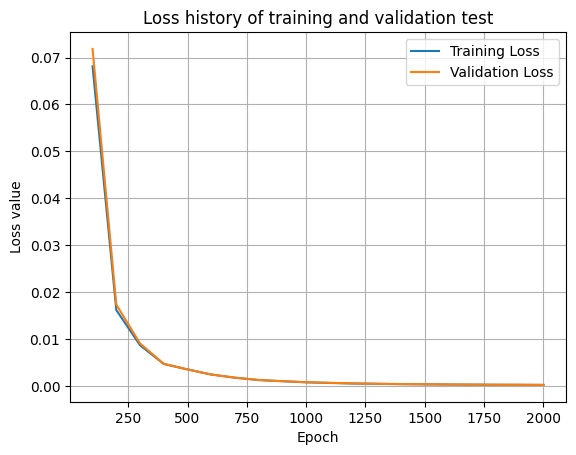

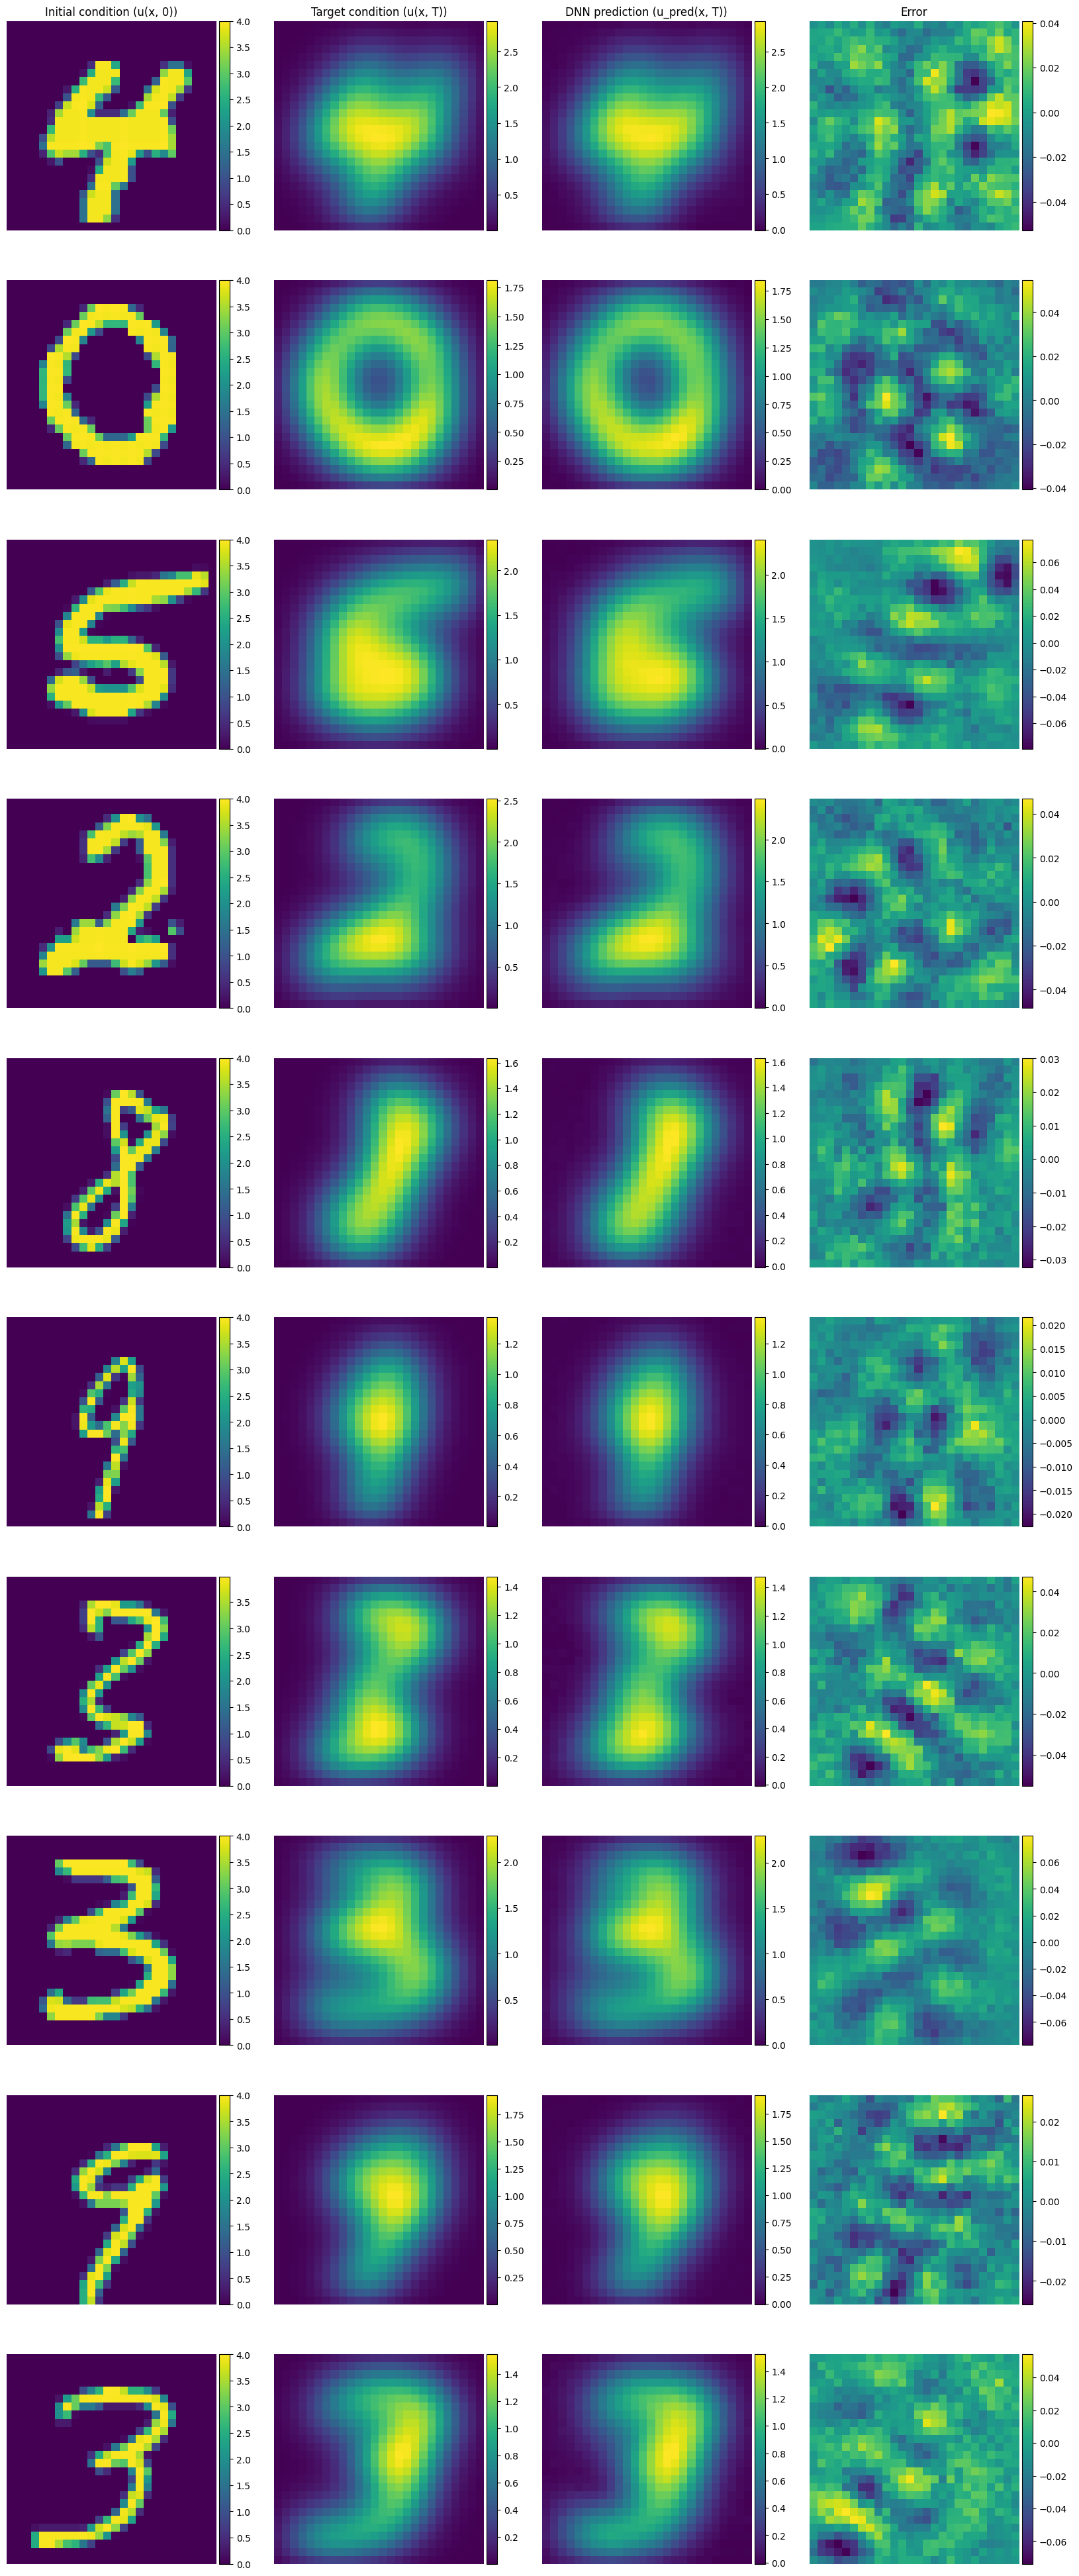

In [ ]:
# write your code here.
#learning rate = 1e-5
model = FullyConnectedNetwork(input_dim=676, output_dim=676, n_layers=8, n_units=700, activation=torch.nn.ReLU())
optimizer_Adam = torch.optim.Adam(model.parameters(), lr=1e-5)
train_and_plot(model=model, optimizer=optimizer_Adam, max_epoches=2000, batch_size=1024)

----------------------------------------------------------------------------------------------------------
Current Optimizer is Adam
Current Epoch: 100/2000
The training loss is 0.12320533394813538
The validation loss is 0.12496951222419739
The mean relative error (in percentage) for the validation set: 0.04170098155736923
Current Epoch: 200/2000
The training loss is 0.12301481515169144
The validation loss is 0.1254039853811264
The mean relative error (in percentage) for the validation set: 0.041773416101932526
Current Epoch: 300/2000
The training loss is 0.12769846618175507
The validation loss is 0.1244775578379631
The mean relative error (in percentage) for the validation set: 0.04161882400512695
Current Epoch: 400/2000
The training loss is 0.12474904954433441
The validation loss is 0.12431633472442627
The mean relative error (in percentage) for the validation set: 0.041591864079236984
Current Epoch: 500/2000
The training loss is 0.12123192846775055
The validation loss is 0.124761626

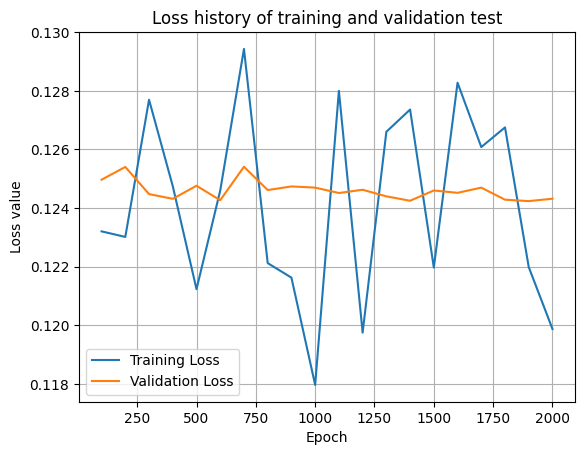

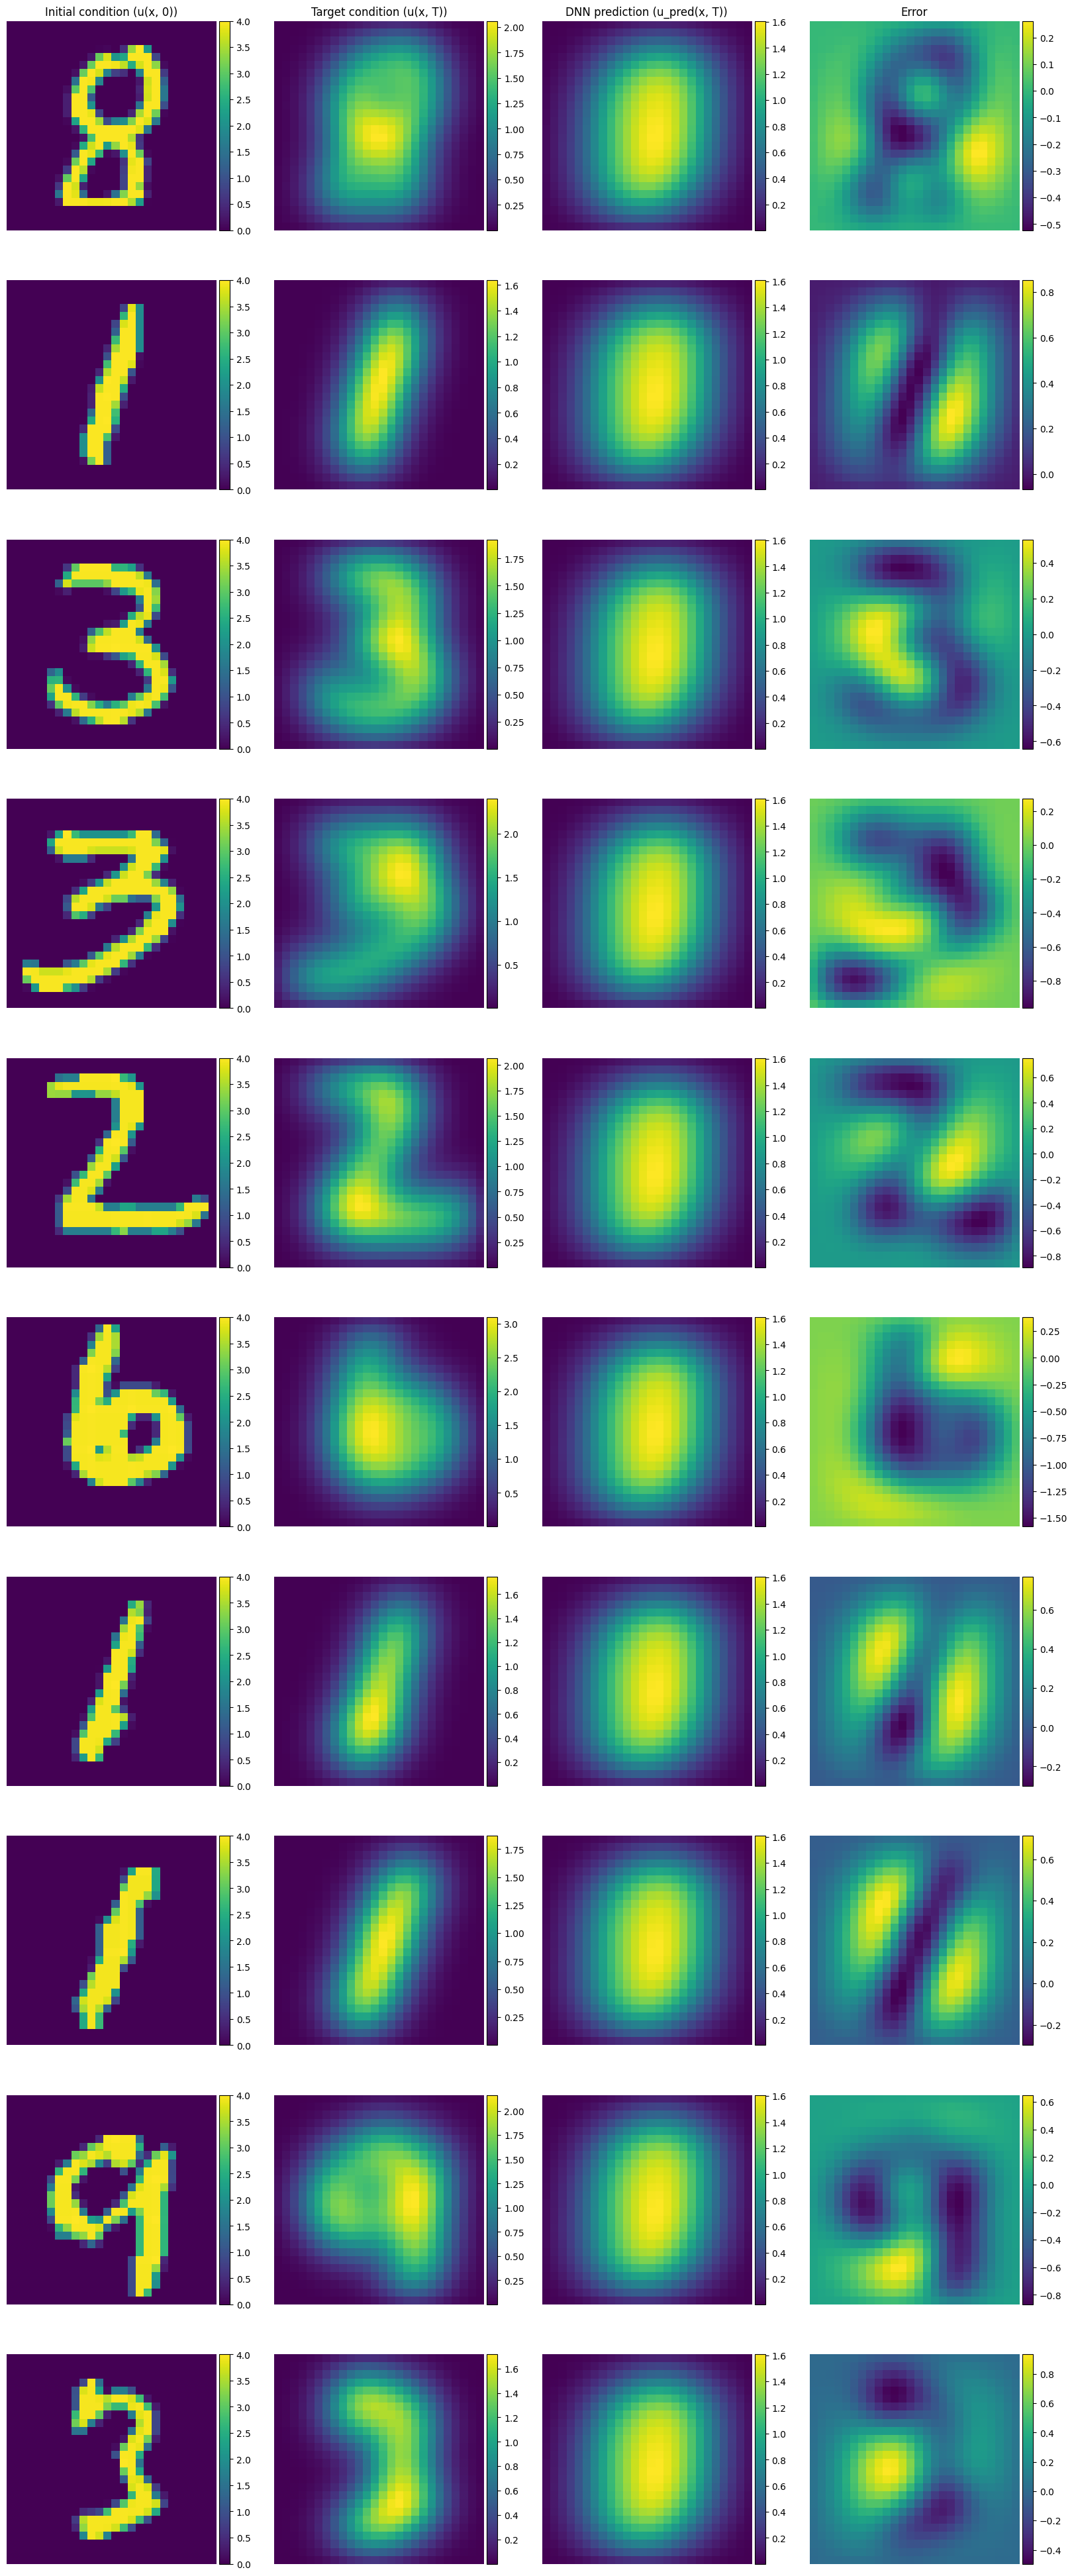

In [ ]:
# write your code here.
#learning rate = 1e-2
model = FullyConnectedNetwork(input_dim=676, output_dim=676, n_layers=8, n_units=700, activation=torch.nn.ReLU())
optimizer_Adam = torch.optim.Adam(model.parameters(), lr=1e-2)
train_and_plot(model=model, optimizer=optimizer_Adam, max_epoches=2000, batch_size=1024)


----------------------------------------------------------------------------------------------------------
Current Optimizer is Adam
Current Epoch: 100/2000
The training loss is nan
The validation loss is nan
The mean relative error (in percentage) for the validation set: nan
Current Epoch: 200/2000
The training loss is nan
The validation loss is nan
The mean relative error (in percentage) for the validation set: nan
Current Epoch: 300/2000
The training loss is nan
The validation loss is nan
The mean relative error (in percentage) for the validation set: nan
Current Epoch: 400/2000
The training loss is nan
The validation loss is nan
The mean relative error (in percentage) for the validation set: nan
Current Epoch: 500/2000
The training loss is nan
The validation loss is nan
The mean relative error (in percentage) for the validation set: nan
Current Epoch: 600/2000
The training loss is nan
The validation loss is nan
The mean relative error (in percentage) for the validation set: nan
Cur

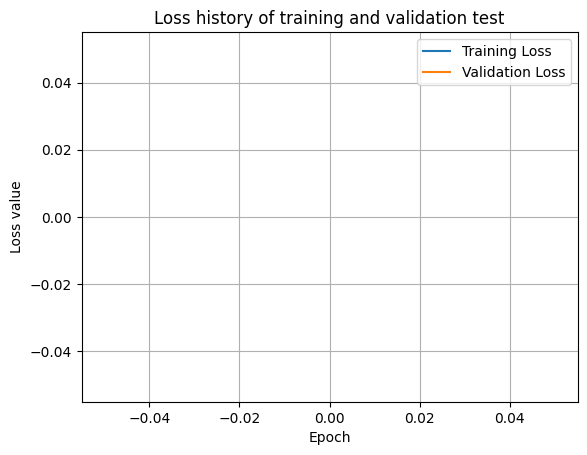

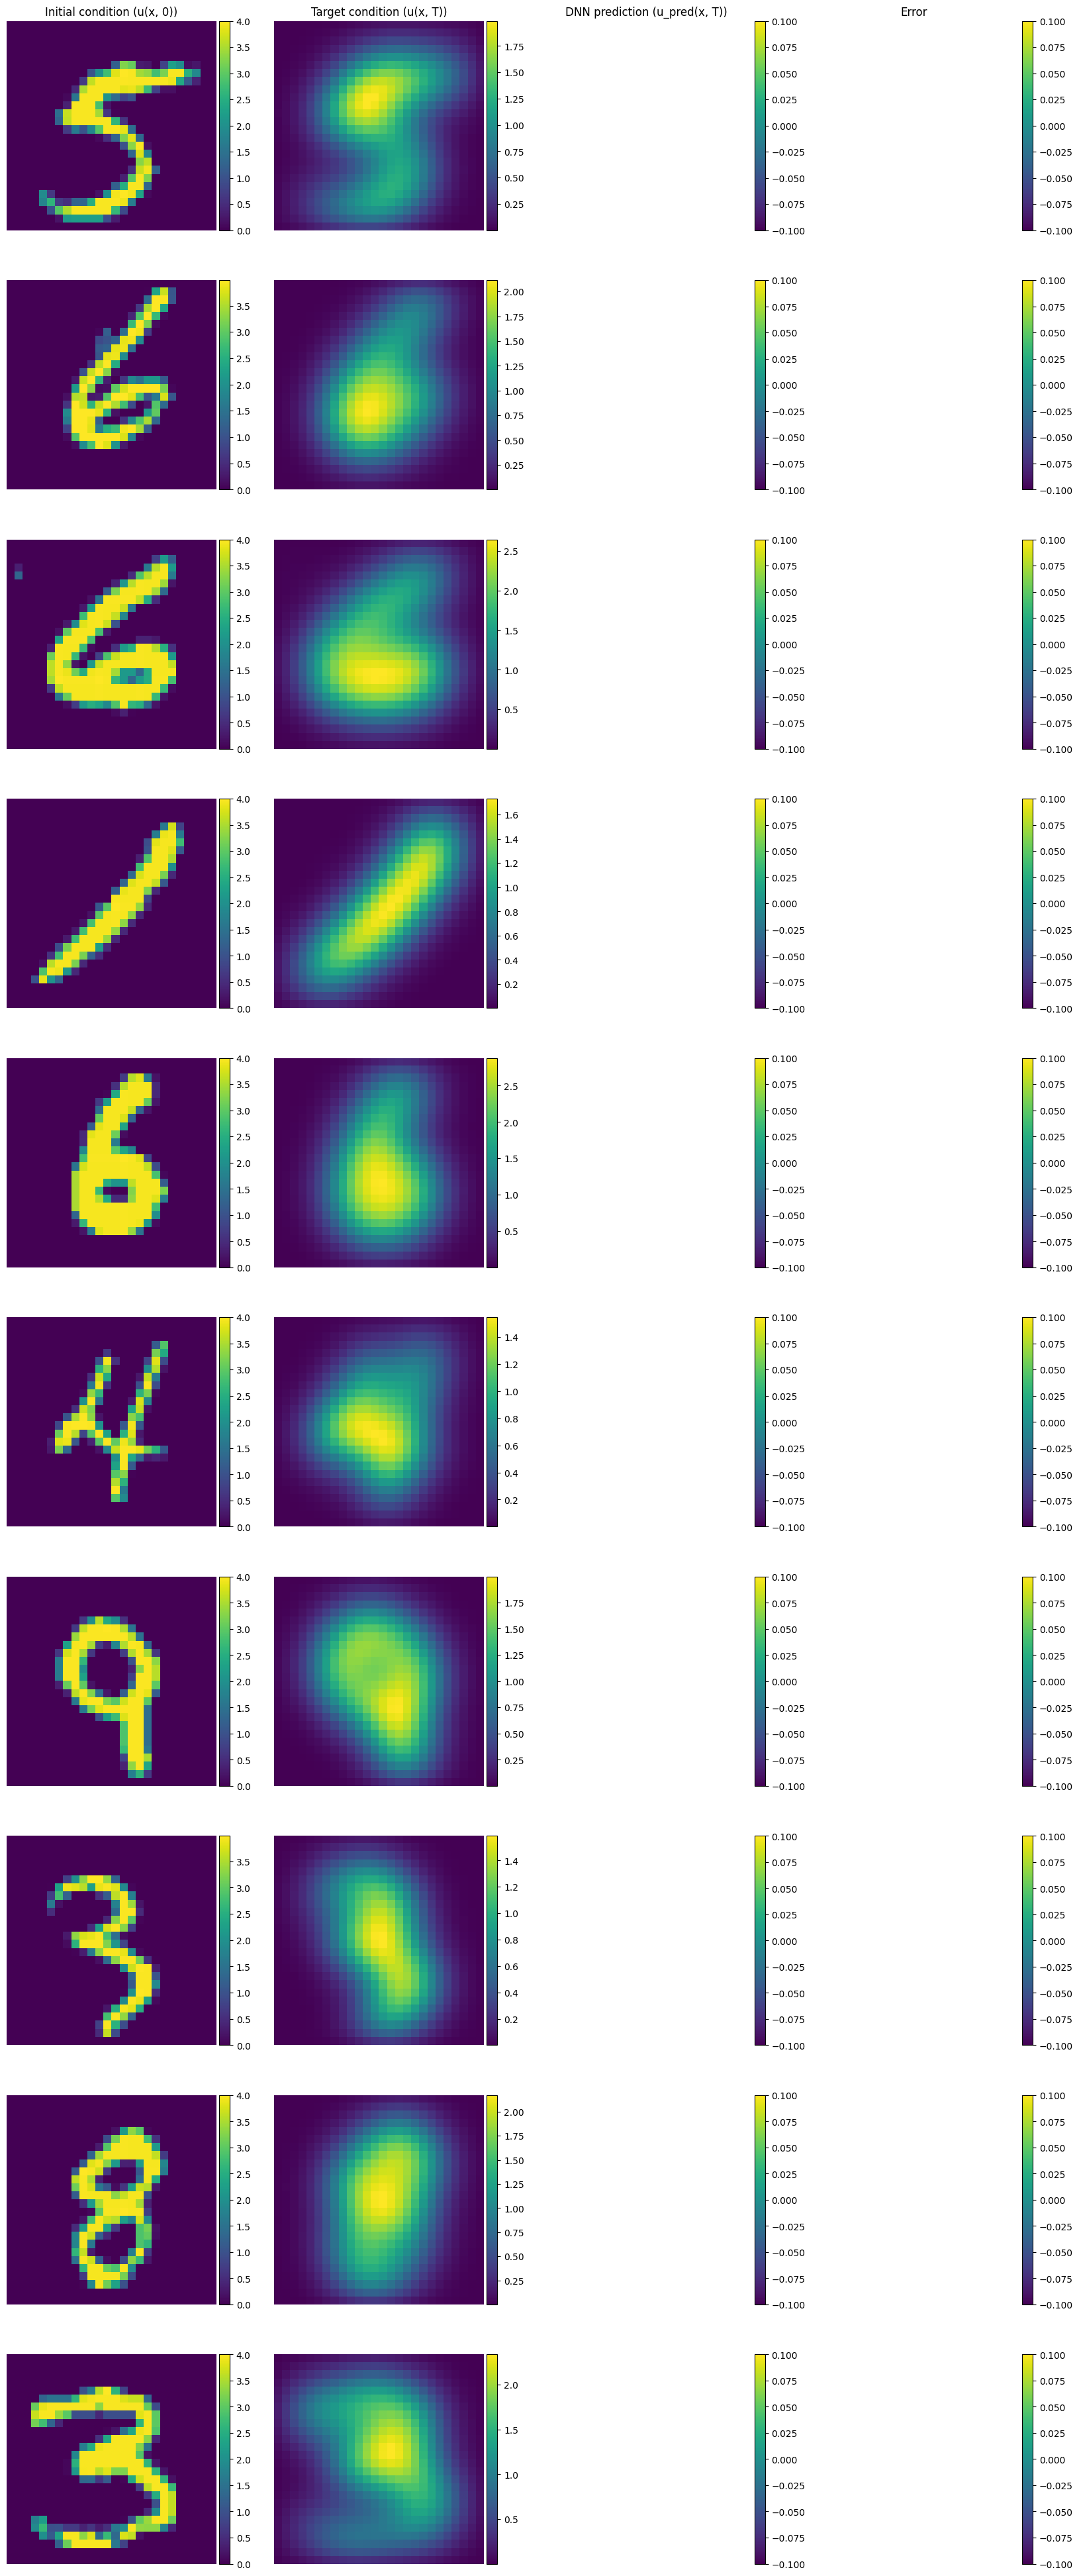

In [ ]:
# write your code here.
#learning rate = 1
model = FullyConnectedNetwork(input_dim=676, output_dim=676, n_layers=8, n_units=700, activation=torch.nn.ReLU())
optimizer_Adam = torch.optim.Adam(model.parameters(), lr=1)
train_and_plot(model=model, optimizer=optimizer_Adam, max_epoches=2000, batch_size=1024)

Use this text cell to: comment on your observations. Which learning rate performs best? Which criteria are you using to
judge the relative performance? Why do you think the specific value of learning rate performed better compared to other two.

When Learning rate = 1e-5: In the graph, both training and validation loss sharply decreasing and then stabilizing at small losses,indicating good convergence. Since both losses decrease in a similar fashion and reach low levels, it suggests that the model is learning effectively without overfitting. Also, The final loss values are very low, suggesting this learning rate is effective for the model.

When Learning rate = 1e-2: In the graph, both the training and validation losses presents fluctuations all the time, indicating the learning is instable. Though the losses show a decreasing trend, such oscillations indicate that this learning rate may be too high, leading to less effective learning compared to first case when Learning rate = 1e-5

When Learning rate = 1: In this case, Though the training and validation losses remains extremely high which possible exceed the range of float.

I'm using the following criteria to judge their performance:

1. Convergence: if the loss smoothly decrease to a low level.
2. Stability:  No large and constant fluctuations are observed
3. Fitting: the model is not overfitting, we have a small gap between the training and validation losses.

the 1e-5 learning rate performs best might be because it converges smoothly to a really low-level loss with little fluctuation and overshoot. Also, the validation and training losses are close to each other, meaning we don't have overfit.

In [ ]:
# !pip install nbconvert
# !apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!jupyter nbconvert --to pdf /content/drive/MyDrive/Colab\ Notebooks/HW5_PartA_starter_code.ipynb


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/HW5_PartA_starter_code.ipynb to pdf
[NbConvertApp] Support files will be in HW5_PartA_starter_code_files/
[NbConvertApp] Making directory ./HW5_PartA_starter_code_files
[NbConvertApp] Making directory ./HW5_PartA_starter_code_files
[NbConvertApp] Making directory ./HW5_PartA_starter_code_files
[NbConvertApp] Making directory ./HW5_PartA_starter_code_files
[NbConvertApp] Making directory ./HW5_PartA_starter_code_files
[NbConvertApp] Making directory ./HW5_PartA_starter_code_files
[NbConvertApp] Making directory ./HW5_PartA_starter_code_files
[NbConvertApp] Making directory ./HW5_PartA_starter_code_files
[NbConvertApp] Making directory ./HW5_PartA_starter_code_files
[NbConvertApp] Making directory ./HW5_PartA_starter_code_files
[NbConvertApp] Making directory ./HW5_PartA_starter_code_files
[NbConvertApp] Making directory ./HW5_PartA_starter_code_files
[NbConvertApp] Making directory ./HW5_PartA_starter_code_files
[